In [128]:
import numpy as np
from scipy.optimize import minimize


In [129]:
def function_scipy(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def grad(x):    
    return np.array([
        -2*(1-x[0]) - 400*x[0]*(x[1] - x[0]**2),
        200*(x[1] - x[0]**2)
    ])

def hess(x):
    return np.array([
        [ 2 - 400*(x[1] - 3*x[0]**2),   -400*x[0] ],
        [ -400*x[0],                     200      ]
    ])

x0 = np.array([-1.2, 1.0])

result = minimize(
    function_scipy,
    x0,
    method="trust-ncg",
    jac=grad,
    hess=hess
)

print(result.x)

[0.9999997  0.99999939]


In [130]:
# Powell's dog leg trust-region solver
def model(g, B, delta):
    # Cauchy point (steepest descent)
    gBg = g @ (B @ g)
    alpha_sd = (g @ g) / gBg
    p_sd = -alpha_sd * g

    # Newton step
    p_newton = -np.linalg.solve(B, g)

    # Check if the Newton step is inside the region
    if np.linalg.norm(p_newton) <= delta:
        return p_newton

    # Check if the Cauchy point is outside of the region
    if np.linalg.norm(p_sd) >= delta:
        return p_sd / np.linalg.norm(p_sd) * delta

    # If not any of those, intersect the two points with the edge of the 
    # region to get the new point
    p_diff = p_newton - p_sd  # point difference
    a = p_diff @ p_diff  # squared 
    b = 2 * (p_sd @ p_diff) # solve the quadratic function
    c = p_sd @ p_sd - delta**2

    tau = (-b + np.sqrt(b*b - 4*a*c)) / (2*a)
    return p_sd + tau * p_diff

# Trust-region algorithm
def trust_region(f, grad, hess, x0, delta0=1.0) -> dict: 
    x = x0.copy()  # save current point
    delta = delta0 # and the delta (or radius)
    eta = 0.15     # aceptance threshold
    history = [x.copy()] # this is for plotting later 
    deltas = [delta] # this one as well

    for k in range(100): # 100 is the number of computations, can change
        g = grad(x) # load the derivative
        B = hess(x) # and the hessian

        # Solve trust-region subproblem
        p = model(g, B, delta)

        # Actual reduction
        f_old = f(x)  # store the current step before the next
        # predicted reduction
        pred = -(g @ p + 0.5 * p @ (B @ p))  # m(0) - m(p) = -(g @ p + 0.5 * p @ (B @ p))

        if pred <= 0:
            delta *= 0.25 #  If pred <= 0 there is no improvement so shrink the delta by 25%
            continue      #  and compute another with a smaller trust region

        rho = (f_old - f(x + p)) / pred  # ratio of the true reduction to predicted reduction
        #                                  to check the model's performance

        # Update the radius based on the ratio
        if rho < 0.25:
            delta *= 0.25
        else:
            if rho > 0.75 and np.linalg.norm(p) > 0.8 * delta: # check how far the step went 
                delta = min(2*delta, 10.0) #  and if it went really close to the border then 
                # increase the delta (with a maximum arbitrary increase of 10)

        if rho > eta:  # if the ratio goes above the threshold then we take 
            x = x + p  # the step without changes
            history.append(x.copy()) # save the path
            deltas.append(delta) # and save the delta
            
        if np.linalg.norm(g) < 1e-6: # if the point is at the minimum (or really close)
            print("x: ", x[0], "y: ", x[1]) # then the algorithm is done.
            break 

    return {"Found minimum" : x, "Path" : np.array(history), "Regions" : np.array(deltas)}



In [131]:
import matplotlib.pyplot as plt

def plot_3d(f, history, x_range=(-3, 3), y_range=(-3, 3)):
    X = np.linspace(*x_range, 200)
    Y = np.linspace(*y_range, 200)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.array([X, Y]))

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, alpha=0.4)

    xs = history[:, 0]
    ys = history[:, 1]
    zs = f(history.T)

    ax.plot(xs, ys, zs, color='red', marker='o', markersize = 3, linewidth=1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")

    plt.show()


In [132]:
from matplotlib.patches import Circle

def plot_trust_regions(f, history, deltas, x_range=(-3,3), y_range=(-3,3), levels=40):
    X = np.linspace(*x_range, 400)
    Y = np.linspace(*y_range, 400)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.array([X, Y]))
    x_final, y_final = history[-1]

    fig, ax = plt.subplots(figsize=(8,7))
    CS = ax.contour(X, Y, Z, levels=levels, cmap='viridis')
    ax.clabel(CS, inline=1, fontsize=8)

    xs = history[:, 0]
    ys = history[:, 1]
    ax.plot(xs, ys, 'ro-', linewidth=2, markersize=4, label="Path")
    
    ax.plot(x_final, y_final, 'go', markersize=12, label="Final minimum")

    for (x, y), delta in zip(history, deltas):
        circle = Circle((x, y), delta, color='blue', alpha=0.1)
        ax.add_patch(circle)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.show()


In [133]:
def fun(x):   
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def derivative_fun(x):
    return np.array([
        -2*(1-x[0]) - 400*x[0]*(x[1] - x[0]**2),
        200*(x[1] - x[0]**2)
    ])

def hessian_fun(x):
    return np.array([
        [ 2 - 400*(x[1] - 3*x[0]**2),   -400*x[0] ],
        [ -400*x[0],                     200      ]
    ])

In [ ]:
def fun(x):   
    return 5*x[0]**2*x[1]**2 + (1 - 3*x[0]**2)**2 + 2*x[1]**4

def derivative_fun(x):
    return np.array([
        10*x[0]*x[1]**2 - 3,
        10*x[1]*x[0]**2 + 8*x[1]**3
    ])

def hessian_fun(x):
    return np.array([
        [10*x[1]**2,   20*x[0]*x[1]],
        [ 20*x[0]*x[1], 10*x[0]**2 + 24*x[1]**2]
    ])

In [135]:
def fun2(x):   
    return x[0]**2 + x[1]**2

def derivative_fun2(x):
    return np.array([ 2*x[0], 2*x[1]])

def hessian_fun2(x):
    return np.array([
        [2,   0],
        [0,   2]
    ])

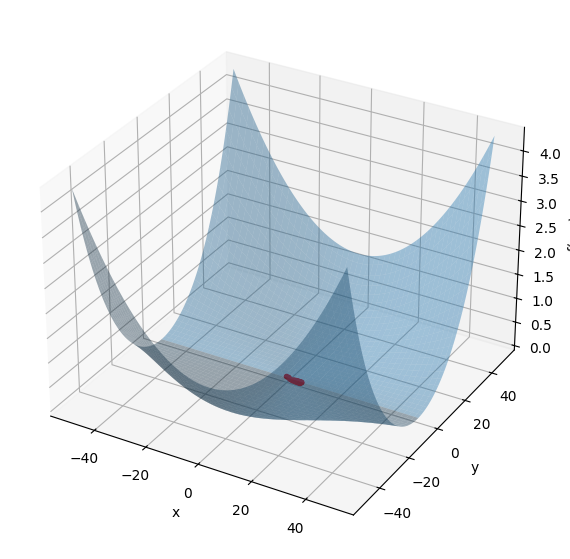

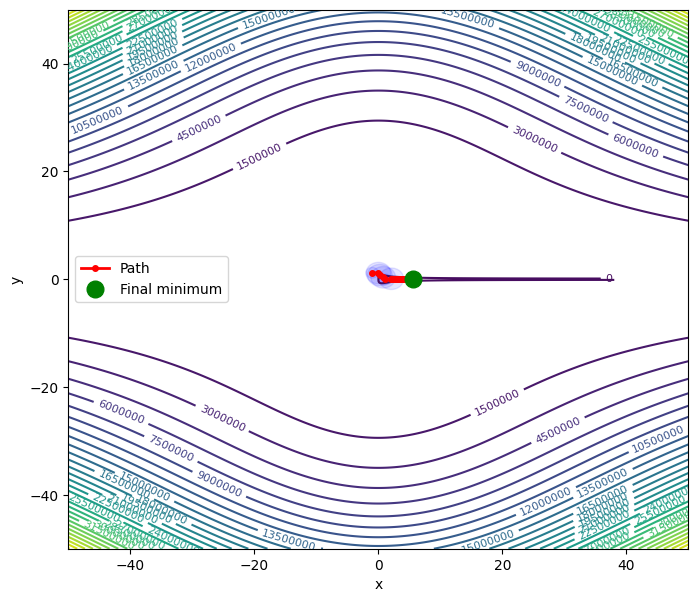

In [136]:
x_opt = trust_region(fun, derivative_fun, hessian_fun, x0=np.array([-1.0, 1.2]))

plot_3d(fun, x_opt["Path"], x_range= (-50, 50), y_range= (-50,50))
plot_trust_regions(fun, x_opt["Path"], x_opt["Regions"], x_range= (-50, 50), y_range= (-50,50))

C:\Users\javie\AppData\Local\Temp\ipykernel_4312\4229910209.py:5: RuntimeWarning: invalid value encountered in scalar divide
  alpha_sd = (g @ g) / gBg


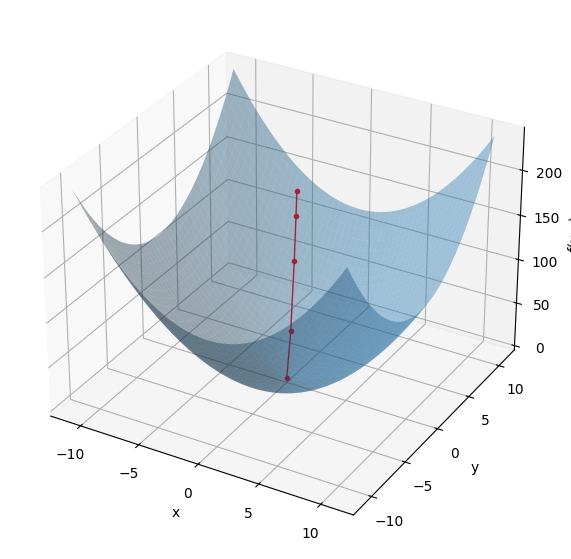

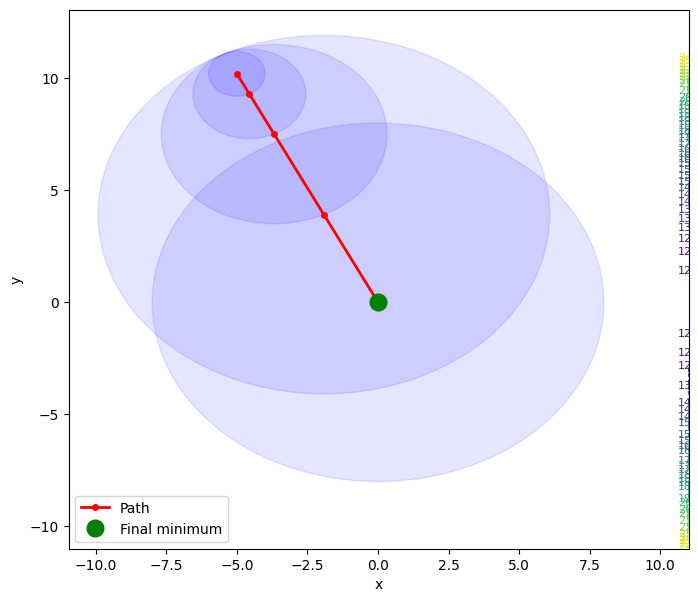

In [137]:
x_opt = trust_region(fun2, derivative_fun2, hessian_fun2, x0=np.array([-5.0, 10.2]))

plot_3d(fun2, x_opt["Path"], x_range= (-11, 11), y_range= (-11, 11))
plot_trust_regions(fun2, x_opt["Path"], x_opt["Regions"], x_range= (11, 11), y_range= (-11, 11))

x:  0.0 y:  0.0


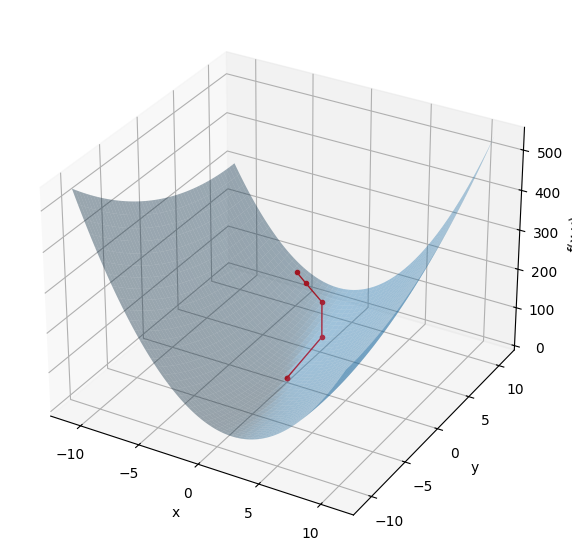

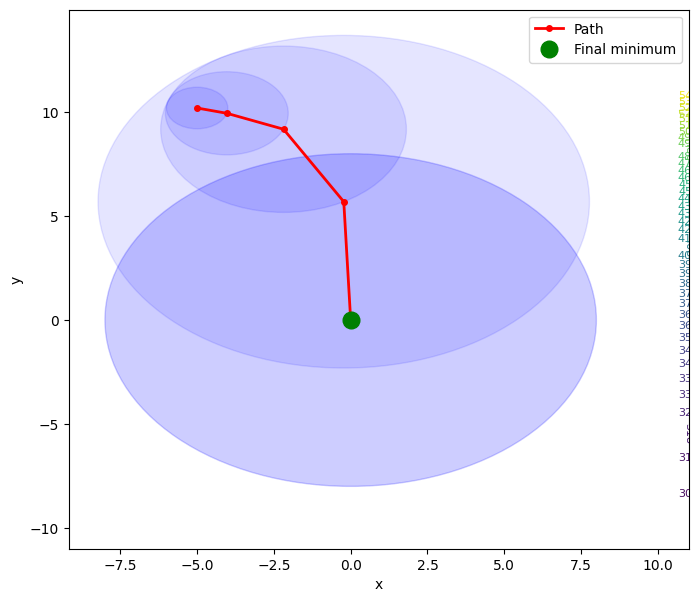

In [138]:
x_opt = trust_region(tilted_bowl, derivative_tilted_bowl, hessian_tilted_bowl, x0=np.array([-5.0, 10.2]))

plot_3d(tilted_bowl, x_opt["Path"], x_range= (-11, 11), y_range= (-11, 11))
plot_trust_regions(tilted_bowl, x_opt["Path"], x_opt["Regions"], x_range= (11, 11), y_range= (-11, 11))